# Квантовый оптимальный контроль для эффективного Гамильтониана

Daniel Rosseau Qianqian Ha and Tim Byrnes, Phys.Rev.A 90, 052315 (2014)

$$ 
H 
    = \frac{ H_\mathrm{ eff } }{ \Omega } 
    = \frac{ \omega }{ \Omega } \underbrace{ \left( S^z_1 +  S^z_2 \right) }_{ H_\mathrm{ control } }
    - \underbrace{ \left( 
        S^z_1 S^z_2 
        + \frac{ \left( S^z_1 \right)^2 }{ 2 }
        + \frac{ \left( S^z_2 \right)^2 }{ 2 }
    \right) }_{ H_\mathrm{ drift } }
$$



In [1]:
import math

import matplotlib.pyplot as plt
import numpy as np
import qutip
from qutip.control.pulseoptim import optimize_pulse_unitary

In [2]:
import pathlib, sys

sys.path.append(str(pathlib.Path(sys.path[0]).parent / "libs"))

In [3]:
%reload_ext autoreload
%autoreload 2

import bec
from tools.jupyter import print_model_info

In [4]:
N_BOSONS = 3
PHASE = 0  # np.pi / 4
model_default = bec.BEC_Qubits.init_default(n_bosons=N_BOSONS, phase=PHASE)


def omega(m):
    return m.g**2 / 2 / m.delta + m.Omega * m.n_bosons / 2


print_model_info(model_default)
print("omega =", omega(model_default))
print("omega / Omega =", omega(model_default) / model_default.Omega)

BEC_Qubits(n_bosons=3, coupling_strength=1, transition_ampl=1, transition_freq=11, resonance_freq=1, phase=0, excitation_level=False, communication_line=False)


<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

omega = 0.05075
omega / Omega = 101.5


In [5]:
def h_drift(m):
    return (
        bec.sz(m, n=2, k=0) * bec.sz(m, n=2, k=1)
        + bec.sz(m, n=2, k=0) ** 2 / 2
        + bec.sz(m, n=2, k=1) ** 2 / 2
    )

[Quantum Optimal Control with Qutip](https://qutip.org/docs/latest/guide/guide-control.html)

$$ H(t) = H_0 + \alpha(t) H_1 + \beta(t) H_2 $$

In [6]:
model = model_default

H0 = h_drift(model)
H1 = bec.sz(model, n=2, k=0)
H2 = bec.sz(model, n=2, k=1)

In [7]:
psi_initial = (
    bec.coherent_state_constructor(model, 2, 0)
    * bec.coherent_state_constructor(model, 2, 1)
    * bec.vacuum_state(model, n=2)
)

In [8]:
qutip.entropy_vn(qutip.ptrace(psi_initial, [0, 1]))

-9.651517497008612e-17

In [9]:
def states_under_hzz_teor(model, t):
    """
    Эволюционные состояния (теория) системы двух кубитов, с начальным суперпозиционным состоянием.
    """

    def alpha(k, t):
        return np.exp(1j * (model.n_bosons - 2 * k) * model.Omega * t) / math.sqrt(2)

    def beta(k, t):
        return alpha(k, t).conjugate()

    return sum(
        (
            math.sqrt(math.comb(model.n_bosons, k))
            * bec.coherent_state_constructor(model, 2, 0, alpha(k, t), beta(k, t))
            * bec.fock_state_constructor(model, 2, 1, k)
            * bec.vacuum_state(model)
        )
        for k in range(model.n_bosons + 1)
    ) / math.sqrt(2**model.n_bosons)

In [10]:
psi_target = states_under_hzz_teor(model, 2 / model.Omega)

In [11]:
qutip.entropy_vn(qutip.ptrace(psi_target, [0, 1]))

1.1420491198826328

In [12]:
nt = 200
t_total = 0.4  # 2 / model.Omega

In [13]:
tspan = np.linspace(0, t_total, nt)
options = qutip.Options(nsteps=1e6)
result = qutip.mesolve(H0 + H1 * 100 + H2 * 100, psi_initial, tspan, options=options)
psi_target = result.states[-1]
qutip.entropy_vn(qutip.ptrace(psi_target, [0, 1]))

1.1405076440577917

In [14]:
%%time
# Fidelity error target
fid_err_targ = 1e-2
# Maximum iterations for the optisation algorithm
max_iter = 100
# Maximum (elapsed) time allowed in seconds
max_wall_time = 180
# Minimum gradient (sum of gradients squared)
# as this tends to 0 -> local minima has been found
min_grad = 1e-10
# pulse type alternatives: RND|ZERO|LIN|SINE|SQUARE|SAW|TRIANGLE|
init_pulse_type = "RND"

result = optimize_pulse_unitary(
    H0,
    [H1, H2],
    psi_initial,
    psi_target,
    num_tslots=nt,
    evo_time=t_total,
    fid_err_targ=fid_err_targ,
    max_iter=max_iter,
    max_wall_time=max_wall_time,
    min_grad=min_grad,
    init_pulse_type=init_pulse_type,
    # dyn_type='SYMPL',
    gen_stats=True,
)

CPU times: user 1h 21min 25s, sys: 3min 11s, total: 1h 24min 37s
Wall time: 11min 33s


In [15]:
result.stats.report()


------------------------------------
---- Control optimisation stats ----
**** Timings (HH:MM:SS.US) ****
Total wall time elapsed during optimisation: 0:11:33.141754
Wall time computing Hamiltonians: 0:00:01.232905 (0.18%)
Wall time computing propagators: 0:11:24.354500 (98.73%)
Wall time computing forward propagation: 0:00:02.375201 (0.34%)
Wall time computing onward propagation: 0:00:00.312379 (0.05%)
Wall time computing gradient: 0:00:04.799191 (0.69%)

**** Iterations and function calls ****
Number of iterations: 1
Number of fidelity function calls: 7
Number of times fidelity is computed: 7
Number of gradient function calls: 6
Number of times gradients are computed: 6
Number of times timeslot evolution is recomputed: 7

**** Control amplitudes ****
Number of control amplitude updates: 6
Mean number of updates per iteration: 6.0
Number of timeslot values changed: 1200
Mean number of timeslot changes per update: 200.0
Number of amplitude values changed: 2400
Mean number of amplitude

In [16]:
result.fidelity

0.0

In [17]:
result.fid_err

0.0009199639744550403

Text(0.5, 1.0, 'Импульсы $ H_0 + \\alpha(t) H_1 + \\beta(t) H_2 $')

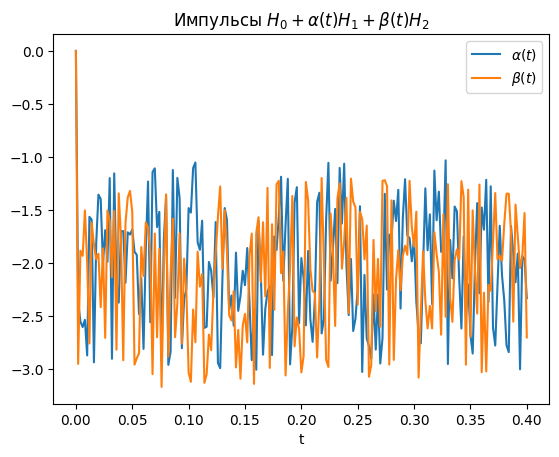

In [18]:
amps = np.vstack(([0, 0], result.final_amps))
_, ax = plt.subplots()
ax.plot(result.time, amps[:, 0], label=r"$\alpha(t)$")
ax.plot(result.time, amps[:, 1], label=r"$\beta(t)$")
ax.set_xlabel("t")
ax.legend()
ax.set_title(r"Импульсы $ H_0 + \alpha(t) H_1 + \beta(t) H_2 $")

In [19]:
options = qutip.Options(nsteps=1e6)
result_amps = qutip.mesolve(
    [H0, [H1, result.final_amps[:, 0]], [H2, result.final_amps[:, 1]]],
    psi_initial,
    tspan,
    options=options,
)

In [20]:
qutip.metrics.fidelity(psi_target, result_amps.states[-1])

0.9990208698764806

In [21]:
qutip.entropy_vn(qutip.ptrace(result_amps.states[-1], [0, 1]))

1.1404599134919975

## Сравение динамики энтропии с $H_\mathrm{control}$ и без

In [22]:
tspan = np.linspace(0, t_total, nt)
options = qutip.Options(nsteps=1e6)
result = qutip.mesolve(H0 + H1 * 100 + H2 * 100, psi_initial, tspan, options=options)
result_ = qutip.mesolve(H0, psi_initial, tspan, options=options)

In [23]:
entropy_span = [qutip.entropy_vn(qutip.ptrace(s, [0, 1])) for s in result.states]
entropy_span_ = [qutip.entropy_vn(qutip.ptrace(s, [0, 1])) for s in result_.states]
entropy_teor_zz_span = [
    qutip.entropy_vn(qutip.ptrace(states_under_hzz_teor(model, t), [0, 1]))
    for t in np.linspace(0, 2 / model.Omega, nt)
]

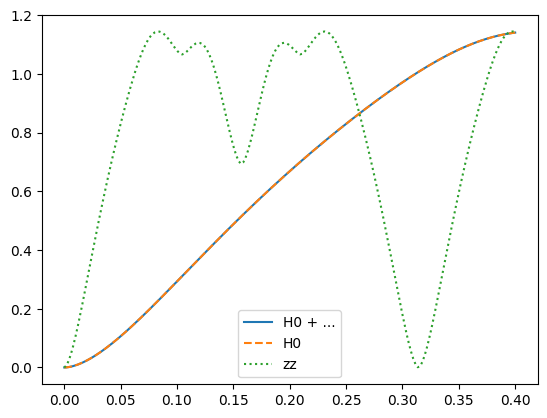

In [24]:
plt.plot(tspan, entropy_span, "-", label="H0 + ...")
plt.plot(tspan, entropy_span_, "--", label="H0")
plt.plot(tspan, entropy_teor_zz_span, ":", label="zz")

plt.legend()

Делаем вывод, что от зеймановской части энропия никак не зависит. 
Это объясняет случайное блуждание импульсов. Остается загадкой почему фиделити ноль... 